# Use LangGraph to create a graph of text2sql application

In [1]:
# !pip install -Uq langchain==0.2.7 langchain-aws langgraph==0.1.5 httpx  shortuuid pymysql pandas pygraphviz matplotlib

## 1. Create database connection

In [25]:
import dotenv
dotenv.load_dotenv('../.env.sample',override=True)

True

- create a mysql connection

In [31]:
from utils.database import ConnectConfigEntity,RelationDatabase,get_sql_result_tool
import shortuuid
import os
mysql_connection = ConnectConfigEntity(id=shortuuid.uuid(),
                                       conn_name='test',
                                       db_type='mysql',
                                       db_name=os.environ['RDS_MYSQL_DBNAME'],
                                       db_host=os.environ['RDS_MYSQL_HOST'],
                                       db_port=os.environ['RDS_MYSQL_PORT'],
                                       db_user=os.environ['RDS_MYSQL_USERNAME'],
                                       db_pwd=os.environ['RDS_MYSQL_PASSWORD'],
                                       comment='test'
                                       )

In [32]:
tables = RelationDatabase.get_all_tables_by_connection(mysql_connection)
schema = RelationDatabase.get_all_schema_names_by_connection(mysql_connection)
print(f'tables:{tables}\nschema:{schema}')

tables:dict_keys(['interactions', 'items', 'users'])
schema:[]


In [33]:
def fetch_ddls(input,connection:ConnectConfigEntity):
    """fetch ddl of given connections 

    Args:
        input (_type_): dummy input
        connection (ConnectConfigEntity): database connection

    Returns:
        _type_: ddl of all tables
    """
    tables = RelationDatabase.get_all_tables_by_connection(connection)
    schema = RelationDatabase.get_all_schema_names_by_connection(connection)
    ddls = RelationDatabase.get_table_definition_by_connection(connection,schema,list(tables))
    return ddls
    

- We use langchain RunnableLambda to wrap the function, so that we can integrate it into the chain.

In [36]:
from langchain_core.runnables import RunnableLambda
from operator import itemgetter

run_fetch_ddls = RunnableLambda(fetch_ddls).bind(connection= mysql_connection)
table_ddls = run_fetch_ddls.invoke('')

In [37]:
print(table_ddls)

{'interactions': {'ddl': 'CREATE TABLE interactions  \n (\n  item_id VARCHAR ,\n  user_id INTEGER ,\n  event_type VARCHAR ,\n  timestamp INTEGER ,\n  discount VARCHAR \n)', 'description': None}, 'items': {'ddl': 'CREATE TABLE items  \n (\n  item_id VARCHAR ,\n  price FLOAT ,\n  category_l1 VARCHAR ,\n  category_l2 VARCHAR ,\n  product_description VARCHAR ,\n  gender VARCHAR ,\n  promoted VARCHAR \n)', 'description': None}, 'users': {'ddl': 'CREATE TABLE users  \n (\n  user_id VARCHAR ,\n  age INTEGER ,\n  gender VARCHAR \n)', 'description': None}}


## 2. Start with a simple Graph
- we will create a intention detection flow
- detect the intent from ["normal_search","reject_search","agent_search","knowledge_search","normal_chat"]

In [38]:
from langchain_aws import ChatBedrock
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_core.output_parsers import StrOutputParser
import sys
sys.setrecursionlimit(2000)
llm = ChatBedrock( model_id="anthropic.claude-3-sonnet-20240229-v1:0",
                  # streaming=True,
                # callbacks=[StreamingStdOutCallbackHandler()],
                model_kwargs=dict(temperature=0.1),
                 credentials_profile_name="default")

llm_fast = ChatBedrock( model_id="anthropic.claude-3-haiku-20240307-v1:0",
                  streaming=True,
                # callbacks=[StreamingStdOutCallbackHandler()],
                model_kwargs=dict(temperature=0.5),
                 credentials_profile_name="default")

In [39]:
import json
import uuid
from datetime import datetime, timezone
from typing import Optional, Tuple
from langchain_core.messages.utils import get_buffer_string
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder
from langchain_core.runnables.config import (
    RunnableConfig,
    ensure_config,
    get_executor_for_config,
)
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode
from typing_extensions import Literal

In [40]:
import operator
from typing import Annotated, Sequence,Dict,Optional,Any,TypedDict,List
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage

class AgentState(TypedDict):
    """The messages in the conversation."""
    messages: Annotated[Sequence[BaseMessage], operator.add]
    env_var: Optional[Annotated[Dict[str, Any], operator.ior]]
    
class GraphConfig(TypedDict):
    """The max loops for generation"""
    max_loops: int = 3

In [41]:
# intention detection system prompt
intent_system_prompt="""You are an intent classifier and entity extractor, and you need to perform intent classification and entity extraction on search queries.
Background: I want to query data in the database, and you need to help me determine the user's relevant intent and extract the keywords from the query statement. Finally, return a JSON structure.

There are 3 main intents:
<intent>
- normal_search: Query relevant data from the data table
- reject_search: Delete data from the table, add data to the table, modify data in the table, display usernames and passwords in the table, and other topics unrelated to data query
- agent_search: Attribution-based problems are not about directly querying the data. Instead, they involve questions like "why" or "how" to understand the underlying reasons and dynamics behind the data.
- knowledge_search: Questions unrelated to data, such as general knowledge, such as meaning for abbviations, terminology explanation, etc.
</intent>

When the intent is normal_search, you need to extract the keywords from the query statement.

Here are some examples:

<example>
## question : 希尔顿在欧洲上线了多少酒店数
## answer :
{{
    "intent" : "normal_search",
    "slot" : ["希尔顿", "欧洲", "上线", "酒店数"]
}}

## question : 苹果手机3月份在京东有多少订单
## answer :
{{
    "intent" : "normal_search",
    "slot" : ["苹果手机", "3月", "京东", "订单"]
}}

## question : 4月份的订单总数是
## answer :
{{
    "intent" : "normal_search",
    "slot" : ["4月", "订单"]
}}

## question : 修改订单表中的第一行数据
## answer :
{{
    "intent" : "reject_search"
}}

## question : 6月份酒店的订单为什么下降了
## answer :
{{
    "intent" : "agent_search"
}}

## question : 希尔顿的英文名是什么
## answer :
{{
    "intent" : "knowledge_search"
}}

## question : 你好，你是谁
## answer :
{{
    "intent" : "normal_chat"
}}
</example>

Please perform intent recognition and entity extraction. Return only the JSON structure, without any other annotations.
"""

In [89]:
# Agent system prompt
agent_system_prompt = """
you are a data analysis expert as well as a retail expert. 
Your current task is to break down the current problem into multiple sub problems based on the problem and the provided data table structure.

<instructions>
1. Fully understand the problem raised by the user
2. Thoroughly understand the data table below
3. Based on the information in the data table, break it down into multiple sub-problems that can be queried through SQL,
4. only output the JSON structure
<instructions>

Here is DDL of the database you are working on:

<table_schema>
{table_schema_data}
</table_schema>

Here are some guidelines you should follow:

<guidelines>

{sql_guidance}

</guidelines> 

Here are some examples of breaking down complex problems into subtasks:

<example>

{example_data}

</example>

Please conduct a thorough analysis of the user's question according to the above instructions, and finally only output the JSON structure without outputting any other content.

"""

In [90]:
# normal chat system prompt
normal_chat_system_prompt="""You are an helpful data analyst assistant. Your name is 'Data Assistant'
"""

### 2.2 Define structural output Object
- We can use langchain's with_structured_output to bind the object, so that llm output can be parsed into the object.

In [91]:
from langchain_core.pydantic_v1 import BaseModel, Field

class Intent(BaseModel):
    """The intent of the user query."""
    intent: Literal["normal_search","reject_search","agent_search","knowledge_search","normal_chat"] = Field(description="The intent of the user query")
    # intent: str = Field(description="The intent of the user query")
    slot: List[str] = Field(default=[], description="The slot of the user query")
    

class Task(BaseModel):
    """a  sub problem."""
    task:str = Field(description="a sub-problem")
    
    
class Tasks(BaseModel):
    """a list of sub problems."""
    tasks: List[Task] = Field(description="A list of sub problems which decomposed from the original problem",
                             min_items=1,
                             max_items=4,
        )
    @property
    def to_str(self) -> str:
        """Return a string representation of the tasks."""
        return "\n".join([task.task for task in self.tasks])
    
    @property
    def to_str_arr(self) -> List[str]:
        """Return a list of string  representation of the tasks."""
        return [task.task for task in self.tasks]
    
class Code(BaseModel):
    """sql code."""
    code:str = Field(description="sql code")

- Test Run

In [92]:
prompt =  ChatPromptTemplate.from_messages(
    [
        (
            "system",
            intent_system_prompt
        ),
        MessagesPlaceholder(variable_name="messages", optional=True)
    ])
chain =  prompt | llm.with_structured_output(Intent)
chain.invoke({"messages":[HumanMessage(content="Tell me a joke about cats")]})

Intent(intent='knowledge_search', slot=[])

In [93]:
chain.invoke({"messages":[HumanMessage(content="6月份酒店的订单为什么下降了")]})

Intent(intent='agent_search', slot=[])

In [94]:
chain.invoke({"messages":[HumanMessage(content="6月份订单总数是")]})

Intent(intent='normal_search', slot=['6月', '订单总数'])

### 2.3 Define nodes for the graph

In [95]:
async def normal_chat(state:AgentState):
    """
    Pure chat with user
    
    Args:
        state (messages): The current state

    Returns:
         dict: The updated state
    """
    messages = state['messages']
    print(messages)
    env_var =  state["env_var"]
    prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            normal_chat_system_prompt
        ),
        MessagesPlaceholder(variable_name="messages", optional=True)
    ])

    chain = prompt | llm 
    response  = chain.invoke({"messages":messages})
    return {"messages":[response],"env_var":{**env_var}}

    

In [96]:
async def intention_detect(state:AgentState):
    """
    Detect the intention of user 
    
    Args:
        state (messages): The current state

    Returns:
         dict: The updated state
    """
    print("---intention_detect---")
    messages = state['messages']
    query  = messages[-1].content
    env_var =  state["env_var"]

    prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            intent_system_prompt
        ),
        MessagesPlaceholder(variable_name="messages", optional=True)
    ])
    structured_llm = llm.with_structured_output(Intent)

    chain = prompt | structured_llm
    response = chain.invoke({"messages":messages})
    
    return {"env_var":{**env_var,"query":query,"intent":response.intent}}
    


In [97]:
async def route_intent(state:AgentState):
    """
    Route by intent 
    
    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with outline
    """
    print("---route_intent---")
    env_var =  state["env_var"]
    intent = env_var.get("intent")
    if intent == 'normal_chat':
        return "normal_chat"
    
    elif intent == 'normal_search':
        return "normal_search"
    
    elif intent == 'agent_search':
        return "agent_search"
    else:
        return END
    

### 2.4 Examples for Prompt 
- You can change the example prompt to your own prompt.

In [148]:
# table_schema_data="""
# """

sql_guidance="""
"""

AGENT_COT_EXAMPLE = """
question: Why did the order sales volume of commodities decline in June?
tables : 

interactions,The data on users' interactions with products, including users' browsing, purchasing, and other behaviors towards the products, are recorded.
items,The product information table records the price, category, description, and other information for each product
users,The user information table records the age and gender of each user.

The analysis approach is as follows:

1. Analyze the total sales volume and sales revenue of the top 10 products.
2. Analyze the purchase situation of the top 10 products by different genders.
3. Analyze the most popular product category with the highest purchase rate.

The corresponding query structure is as follows:
answer:
```json
{"tasks":[
    {"task": "Analyze the total sales volume and sales revenue of the top 10 products."},
    {"task": "Analyze the purchase situation of the top 10 products by different genders"},
    {"task": "Analyze the most popular product category with the highest purchase rate."}]
}
```
"""

In [149]:
async def normal_search(state:AgentState):
    """Only componse the user query as a task

    Args:
        state (AgentState): _description_

    Returns:
        _type_: _description_
    """
    print("---normal_search---")
    messages = state['messages']
    env_var =  state["env_var"]
    tasks = Tasks(tasks=[Task(task=messages[-1].content)])
    return {"env_var":{**env_var,"tasks":tasks}}

In [105]:
async def agent_search(state:AgentState):
    """use cot agent to decompose the query into tasks

    Args:
        state (AgentState): _description_

    Returns:
        _type_: _description_
    """
    print("---agent_search---")
    messages = state['messages']
    env_var =  state["env_var"]

    prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            agent_system_prompt
        ),
        MessagesPlaceholder(variable_name="messages", optional=True)
    ])

    chain = (
            #table_schema_data is retreived by invoke fetch_ddls
             {"table_schema_data":RunnableLambda(fetch_ddls).bind(connection= mysql_connection),
              "sql_guidance":itemgetter("sql_guidance"),
              "example_data":itemgetter("example_data"),
              "messages":itemgetter("messages"),              
              }) | prompt | llm.with_structured_output(Tasks)
    response = chain.invoke({"messages":messages,"sql_guidance":sql_guidance,"example_data":AGENT_COT_EXAMPLE})
    
    return {"env_var":{**env_var,"tasks":response}}

### 2.5 Build a simple graph and test

In [106]:
# Create the graph and add nodes
builder = StateGraph(AgentState)
builder.add_node("intention_detect",intention_detect)
builder.add_node("normal_chat",normal_chat)
builder.add_node("agent_search",agent_search)
builder.add_node("normal_search",normal_search)

# Add edges to the graph
builder.add_edge(START, "intention_detect")

builder.add_conditional_edges("intention_detect", route_intent)
builder.add_edge("normal_chat",END)
builder.add_edge("normal_search",END)
builder.add_edge("agent_search",END)

# Compile the graph
workflow = builder.compile()

- plot the graph

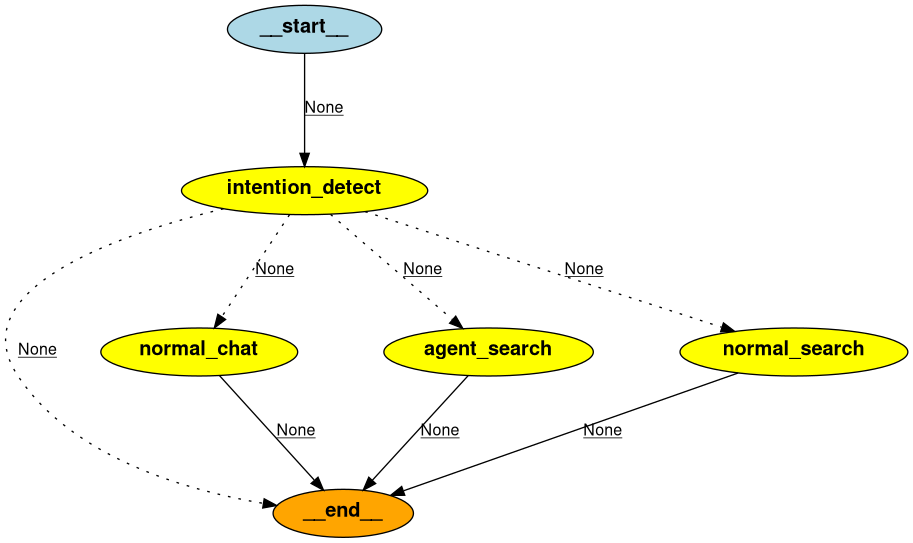

In [107]:

from IPython.display import Image

Image(workflow.get_graph().draw_png())

- Test Run

In [150]:
# query = "最近一周的订单总数"
query = "6月的销售情况为什么下降了"
# query = "你好，你是谁"
steps = []
init_state = {
    "env_var":{},
    "messages":[HumanMessage(content=query)]
}


In [151]:
async for event in workflow.astream(input=init_state):
    steps.append(event)
    for key, value in event.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

---intention_detect---


---route_intent---
Output from node 'intention_detect':
---
{'env_var': {'query': '6月的销售情况为什么下降了', 'intent': 'agent_search'}}

---

---agent_search---
Output from node 'agent_search':
---
{'env_var': {'query': '6月的销售情况为什么下降了', 'intent': 'agent_search', 'tasks': Tasks(tasks=[Task(task='分析每月销售总额的变化趋势'), Task(task='分析热门商品类别的月销售额变化'), Task(task='分析不同年龄段用户的月购买情况'), Task(task='分析促销活动对月销售额的影响')])}}

---

---text_to_sql---
---execute_sql---
---should_continue---
---text_to_sql---
---execute_sql---
---should_continue---
---text_to_sql---
---execute_sql---
---should_continue---
Output from node 'txt2sql_subgraph':
---
{'messages': [HumanMessage(content='6月的销售情况为什么下降了')], 'env_var': {'query': '6月的销售情况为什么下降了', 'intent': 'agent_search', 'tasks': Tasks(tasks=[Task(task='分析每月销售总额的变化趋势'), Task(task='分析热门商品类别的月销售额变化'), Task(task='分析不同年龄段用户的月购买情况'), Task(task='分析促销活动对月销售额的影响')]), 'codes': [Code(code="SELECT \n  EXTRACT(YEAR_MONTH FROM FROM_UNIXTIME(`timestamp`)) AS `year_month`,\n  SUM(`items`.`price`) 

## 3. Create a code generation and execution sub graph

### 3.1 Create text 2 sql chain

In [152]:
TOP_K = 100
MYSQL_DIALECT_PROMPT_CLAUDE3 = """
You are a data analysis expert and proficient in MySQL. Given an input question, create a syntactically correct MySQL query to run.
Unless the user specifies in the question a specific number of examples to obtain, query for at most {top_k} results using the LIMIT clause as per MySQL. 
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in backticks (`) to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use CURDATE() function to get the current date, if the question involves "today". Aside from giving the SQL answer, concisely explain yourself after giving the answer
""".format(top_k=TOP_K)

TEXT2SQL_RPOMPT= MYSQL_DIALECT_PROMPT_CLAUDE3 + \
"""
Assume a database with the following tables and columns exists:
Given the following database schema, transform the following natural language requests into valid SQL queries.
<table_schema>
{table_info}
</table_schema>

Here are some examples of generated SQL using natural language.
<examples>
{examples}
</examples> 

Here are some ner info to help generate SQL.
<ner_info>
{ner_info}
</ner_info> 

Think about the sql question before continuing. If it's not about writing SQL statements, say 'Sorry, please ask something relating to querying tables'.
Think about your answer first before you respond.  
"""

In [153]:
def single_text_generate_code(messages):
    """generate sql code from single task

    Args:
        messages (_type_): chat messages

    Returns:
        _type_: Code object
    """
    prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            TEXT2SQL_RPOMPT,
        ),
        MessagesPlaceholder(variable_name="messages", optional=True)
    ])
    chain = ({"table_info":RunnableLambda(fetch_ddls).bind(connection= mysql_connection),
              "examples":itemgetter("examples"),
              "ner_info":itemgetter("ner_info"),
              "messages":itemgetter("messages")
              }) | prompt | llm.with_structured_output(Code)
    response = chain.invoke({"messages":messages,"ner_info":"","examples":""})
    return response
    

- test run

In [154]:
runnable_gen_task = RunnableLambda(single_text_generate_code)
code = runnable_gen_task.invoke([HumanMessage(content="查询订单总数")])
code

Code(code='SELECT COUNT(*) AS total_orders\nFROM interactions;')

- Test run in parrallel

In [155]:
# Test run in parrallel
await runnable_gen_task.abatch([[HumanMessage(content="查询订单总数")],
                                [HumanMessage(content="查询用户总数")]])

[Code(code='SELECT COUNT(*) AS total_orders\nFROM interactions;'),
 Code(code='SELECT COUNT(DISTINCT `user_id`) AS total_users\nFROM `users`;')]

- Test execution

In [156]:
sql = "SELECT COUNT(*) AS total_orders\nFROM interactions;"
db_result = RunnableLambda(get_sql_result_tool).bind(connection=mysql_connection).batch([sql])
db_result

[{'data':    total_orders
  0        675004,
  'sql': 'SELECT COUNT(*) AS total_orders\nFROM interactions;',
  'status_code': 200,
  'error_info': ''}]

### 3.2 create text2sql and execution subGraph
- This subgraph is used to create the text2sql and execution sql code in parralel
- It has reflect loop to feedback the execution error and re-gnerate the sql code

In [157]:
class ChildState(TypedDict):
    """The messages in the conversation."""
    messages: Annotated[Sequence[BaseMessage], operator.add]
    env_var: Optional[Annotated[Dict[str, Any], operator.ior]]

In [123]:
async def text_to_sql(state:ChildState):
    print("---text_to_sql---")
    messages = state['messages']
    env_var =  state["env_var"]
    error_info = env_var.get('error_info',[])
    
    # loops counter
    loop_cnt = 1 if not env_var.get('loop_cnt') else env_var['loop_cnt']+1
    tasks_obj = env_var["tasks"]
    if not error_info:
        task_arrs = [ [HumanMessage(content=task_obj.task)] for task_obj  in tasks_obj.tasks]
    else:
        # if there is error in last round, then fix it
        task_arrs = [ [HumanMessage(content=task_obj.task),
                       AIMessage(content=info), 
                       HumanMessage(content='fix the code')] if info else [HumanMessage(content=task_obj.task)]
                            for task_obj, info in zip(tasks_obj.tasks,error_info)]
    # print(task_arrs)
    # Run in parallel
    codes = await RunnableLambda(single_text_generate_code).abatch(task_arrs)
    return {"env_var":{**env_var,"codes":codes,"loop_cnt":loop_cnt}}
    

In [124]:
MAX_LOOPS = 3
async def execute_sql(state:ChildState):
    print("---execute_sql---")
    messages = state['messages']
    env_var =  state["env_var"]
    codes = env_var["codes"]
    sql_codes = [code.code for code in codes]
    
    results = await RunnableLambda(get_sql_result_tool).bind(connection=mysql_connection).abatch(sql_codes)
    
    #retrieve error to construct message
    error_info = []
    
    for ret in results:
        content = ''
        if ret['status_code'] != 200:
            content = f"The sql:\n```sql\n{ret['sql']}```\nhas execution errors:{ret['error_info']}\n"
            print(ret['error_info'])
        error_info.append(content)
        
    
    return {"env_var":{**env_var,"query_results":results,"error_info":error_info}}

async def should_continue(state:ChildState):
    """
    a conditional edge 
    
    Args:
        state (messages): The current state

    Returns:
         str: the node name
    """
    print("---should_continue---")
    env_var =  state["env_var"]
    error_info = env_var['error_info']
    loop_cnt = env_var['loop_cnt']
    
    #if reach the max loops the end
    if loop_cnt >= MAX_LOOPS or (not error_info) :
         return END
    else:
        return 'text_to_sql'
    

In [125]:
child_builder = StateGraph(ChildState)
child_builder.add_node("text_to_sql",text_to_sql)
child_builder.add_node("execute_sql",execute_sql)

child_builder.add_edge(START, "text_to_sql")
child_builder.add_edge("text_to_sql", "execute_sql")
child_builder.add_conditional_edges("execute_sql",should_continue)

child_workflow = child_builder.compile()



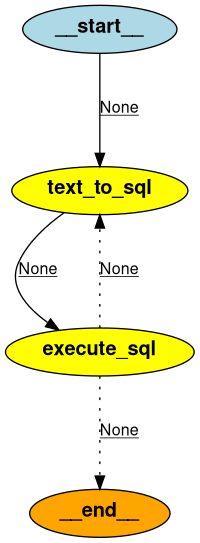

In [147]:
Image(child_workflow.get_graph().draw_png())

- Test the subgraph

In [126]:
test_tasks = Tasks(tasks=[Task(task='查询订单总数'),Task(task='分析不同地区的销售情况,看哪些地区销售下降较多')])
steps = []
init_state = {
    "env_var":{"tasks":test_tasks},
}
async for event in child_workflow.astream(input=init_state):
    steps.append(event)
    for key, value in event.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

---text_to_sql---


Output from node 'text_to_sql':
---
{'env_var': {'tasks': Tasks(tasks=[Task(task='查询订单总数'), Task(task='分析不同地区的销售情况,看哪些地区销售下降较多')]), 'codes': [Code(code='SELECT COUNT(*) AS total_orders\nFROM interactions;'), Code(code="SELECT \n  `category_l1`, \n  COUNT(*) AS total_interactions\nFROM \n  interactions i\nJOIN \n  items it ON i.`item_id` = it.`item_id`\nWHERE \n  i.`event_type` = 'purchase'\nGROUP BY \n  `category_l1`\nORDER BY \n  total_interactions DESC;")], 'loop_cnt': 1}}

---

---execute_sql---
---should_continue---
Output from node 'execute_sql':
---
{'env_var': {'tasks': Tasks(tasks=[Task(task='查询订单总数'), Task(task='分析不同地区的销售情况,看哪些地区销售下降较多')]), 'codes': [Code(code='SELECT COUNT(*) AS total_orders\nFROM interactions;'), Code(code="SELECT \n  `category_l1`, \n  COUNT(*) AS total_interactions\nFROM \n  interactions i\nJOIN \n  items it ON i.`item_id` = it.`item_id`\nWHERE \n  i.`event_type` = 'purchase'\nGROUP BY \n  `category_l1`\nORDER BY \n  total_interactions DESC;")], 'loop_cnt'

## 3. Add the sub Graph to the Main graph

### 3.1 Create a generate response node to generate date analysis report

In [127]:
CLAUDE3_DATA_ANALYSE_SYSTEM_PROMPT = """
You are a data analysis expert in the retail industry
"""

CLAUDE3_AGENT_DATA_ANALYSE_USER_PROMPT = """
As a professional data analyst, you are now asked a question by a user, and you need to analyze the data provided.

<instructions>
- Analyze the data based on the provided data, without creating non-existent data. It is crucial to only analyze the provided data.
- Perform relevant correlation analysis on the relationships between the data.
- There is no need to expose the specific SQL fields.
- The data related to the user's question is in a JSON result, which has been broken down into multiple sub-questions, including the sub-questions, queries, SQL, and data_result.
</instructions>


The user question is：{question}

The data related to the question is：{data}

Think step by step.
"""

CLAUDE3_QUERY_DATA_ANALYSE_USER_PROMPT = """

Your task is to analyze the given data and describe it in natural language. 

<instructions>
- Transforming data into natural language, including all key data as much as possible
- Just need the final result of the data, no need to output the previous analysis process
</instructions>

The user question is：{question}

The data is：{data}

"""

def _generate_llm_response(question:str, data:str, intent:str):
    """invoke a llm chain to generate response

    Args:
        question (str): user's original question
        data (str): sql query data
        intent (str): agent_search or normal_search

    Returns:
        _type_: _description_
    """
    prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            CLAUDE3_DATA_ANALYSE_SYSTEM_PROMPT ,
        ),
        ('human',CLAUDE3_AGENT_DATA_ANALYSE_USER_PROMPT if intent == 'agent_search' else CLAUDE3_QUERY_DATA_ANALYSE_USER_PROMPT)
    ])
    chain = prompt | llm | StrOutputParser()
    resp = chain.invoke({"question": question, "data": data})
    return resp

async def generate_response(state:AgentState):
    """generate response node

    Args:
        state (AgentState): _description_

    Returns:
        _type_: state
    """
    print("---generate_response---")
    env_var =  state["env_var"]
    #original query
    query = env_var['query']
    #decomposed tasks
    tasks = env_var['tasks'].to_str_arr
    intent= env_var['intent']
    #results of execution
    query_results = env_var['query_results']
    
    consolidated_results = [{"query":t,
                                "sql":q['sql'],
                                "data":q['data'].to_json(orient='records')}  for t,q in zip(tasks,query_results)]
    data = json.dumps(consolidated_results,ensure_ascii=False)
    response = _generate_llm_response(query, data,intent)
    return {
        "env_var": {
            **env_var,
            "final_response": response
        }
    }
    

### 3.2 merge the subgraph to main graph

In [128]:
# Create the graph and add nodes
builder = StateGraph(AgentState)
builder.add_node("intention_detect",intention_detect)
builder.add_node("normal_chat",normal_chat)
builder.add_node("agent_search",agent_search)
builder.add_node("normal_search",normal_search)

# add the subgraph to the main graph as a node
builder.add_node("txt2sql_subgraph", child_builder.compile())

builder.add_node("generate_response",generate_response)

# Add edges to the graph
builder.add_edge(START, "intention_detect")

builder.add_conditional_edges("intention_detect", route_intent)
builder.add_edge("normal_search","txt2sql_subgraph")
builder.add_edge("agent_search","txt2sql_subgraph")
builder.add_edge("txt2sql_subgraph","generate_response")
builder.add_edge("normal_chat",END)
builder.add_edge("generate_response",END)
# Compile the graph
workflow = builder.compile()

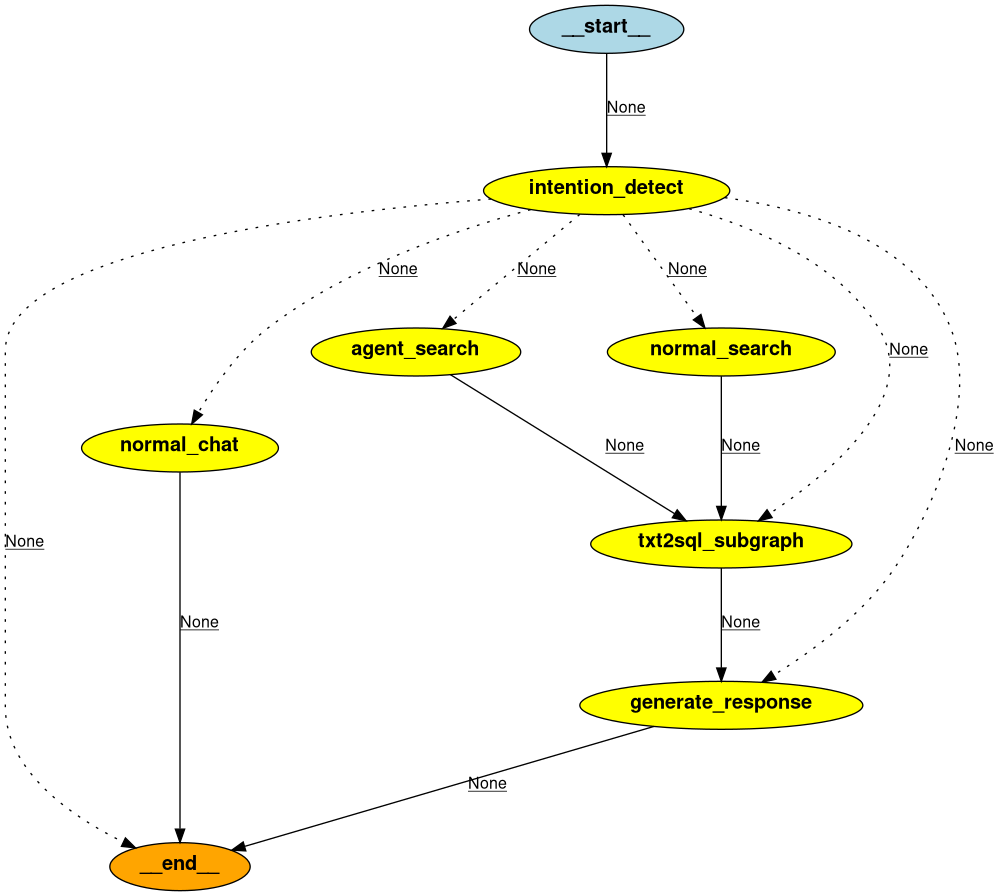

In [146]:

Image(workflow.get_graph().draw_png())

- Test Run

In [158]:
querys = ["订单总数是多少",
          "分析整体的销售情况",
          "6月的销售为什么下降了？"]
steps = []
init_state = {
    "env_var":{},
    "messages":[HumanMessage(content=querys[2])]
}

In [159]:
async for event in workflow.astream(input=init_state):
    steps.append(event)
    for key, value in event.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

---intention_detect---


---route_intent---
Output from node 'intention_detect':
---
{'env_var': {'query': '6月的销售为什么下降了？', 'intent': 'agent_search'}}

---

---agent_search---
Output from node 'agent_search':
---
{'env_var': {'query': '6月的销售为什么下降了？', 'intent': 'agent_search', 'tasks': Tasks(tasks=[Task(task='分析每月总销售额和销量的变化趋势'), Task(task='分析热门商品类别每月销售额和销量的变化'), Task(task='分析不同性别和年龄段用户每月购买行为的变化'), Task(task='分析促销活动对每月销售额和销量的影响')])}}

---

---text_to_sql---
---execute_sql---
---should_continue---
---text_to_sql---


get_sql_result is error: (pymysql.err.ProgrammingError) (1064, "You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'year_month,\n  COUNT(DISTINCT i.`item_id`) AS num_items_purchased\nFROM `interacti' at line 12")
[SQL: SELECT 
  u.`gender`, 
  CASE
    WHEN u.`age` BETWEEN 0 AND 17 THEN '0-17'
    WHEN u.`age` BETWEEN 18 AND 24 THEN '18-24'
    WHEN u.`age` BETWEEN 25 AND 34 THEN '25-34'
    WHEN u.`age` BETWEEN 35 AND 44 THEN '35-44'
    WHEN u.`age` BETWEEN 45 AND 54 THEN '45-54'
    WHEN u.`age` BETWEEN 55 AND 64 THEN '55-64'
    ELSE '65+' 
  END AS age_group,
  DATE_FORMAT(FROM_UNIXTIME(`timestamp`), '%%Y-%%m') AS year_month,
  COUNT(DISTINCT i.`item_id`) AS num_items_purchased
FROM `interactions` i
JOIN `users` u ON i.`user_id` = u.`user_id`
WHERE i.`event_type` = 'purchase'
GROUP BY u.`gender`, age_group, year_month
ORDER BY year_month;]
(Background on this error at: https://sqlalche.me/e/20/f405)

---execute_sql---
(pymysql.err.ProgrammingError) (1064, "You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'year_month,\n  COUNT(DISTINCT i.`item_id`) AS num_items_purchased\nFROM `interacti' at line 12")
[SQL: SELECT 
  u.`gender`, 
  CASE
    WHEN u.`age` BETWEEN 0 AND 17 THEN '0-17'
    WHEN u.`age` BETWEEN 18 AND 24 THEN '18-24'
    WHEN u.`age` BETWEEN 25 AND 34 THEN '25-34'
    WHEN u.`age` BETWEEN 35 AND 44 THEN '35-44'
    WHEN u.`age` BETWEEN 45 AND 54 THEN '45-54'
    WHEN u.`age` BETWEEN 55 AND 64 THEN '55-64'
    ELSE '65+' 
  END AS age_group,
  DATE_FORMAT(FROM_UNIXTIME(`timestamp`), '%%Y-%%m') AS year_month,
  COUNT(DISTINCT i.`item_id`) AS num_items_purchased
FROM `interactions` i
JOIN `users` u ON i.`user_id` = u.`user_id`
WHERE i.`event_type` = 'purchase'
GROUP BY u.`gender`, age_group, year_month
ORDER BY year_month;]
(Background on this error at: https://sqlalche.me/e/20/f405)
---sho

get_sql_result is error: (pymysql.err.ProgrammingError) (1064, "You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'year_month,\n  COUNT(DISTINCT i.`item_id`) AS num_items_purchased\nFROM `interacti' at line 12")
[SQL: SELECT
  u.`gender`,
  CASE
    WHEN u.`age` BETWEEN 0 AND 17 THEN '0-17'
    WHEN u.`age` BETWEEN 18 AND 24 THEN '18-24'
    WHEN u.`age` BETWEEN 25 AND 34 THEN '25-34'
    WHEN u.`age` BETWEEN 35 AND 44 THEN '35-44'
    WHEN u.`age` BETWEEN 45 AND 54 THEN '45-54'
    WHEN u.`age` BETWEEN 55 AND 64 THEN '55-64'
    ELSE '65+'
  END AS age_group,
  DATE_FORMAT(FROM_UNIXTIME(i.`timestamp`), '%%Y-%%m') AS year_month,
  COUNT(DISTINCT i.`item_id`) AS num_items_purchased
FROM `interactions` i
JOIN `users` u ON i.`user_id` = u.`user_id`
WHERE i.`event_type` = 'purchase'
GROUP BY u.`gender`, age_group, year_month
ORDER BY year_month;]
(Background on this error at: https://sqlalche.me/e/20/f405)


---execute_sql---
(pymysql.err.ProgrammingError) (1064, "You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'year_month,\n  COUNT(DISTINCT i.`item_id`) AS num_items_purchased\nFROM `interacti' at line 12")
[SQL: SELECT
  u.`gender`,
  CASE
    WHEN u.`age` BETWEEN 0 AND 17 THEN '0-17'
    WHEN u.`age` BETWEEN 18 AND 24 THEN '18-24'
    WHEN u.`age` BETWEEN 25 AND 34 THEN '25-34'
    WHEN u.`age` BETWEEN 35 AND 44 THEN '35-44'
    WHEN u.`age` BETWEEN 45 AND 54 THEN '45-54'
    WHEN u.`age` BETWEEN 55 AND 64 THEN '55-64'
    ELSE '65+'
  END AS age_group,
  DATE_FORMAT(FROM_UNIXTIME(i.`timestamp`), '%%Y-%%m') AS year_month,
  COUNT(DISTINCT i.`item_id`) AS num_items_purchased
FROM `interactions` i
JOIN `users` u ON i.`user_id` = u.`user_id`
WHERE i.`event_type` = 'purchase'
GROUP BY u.`gender`, age_group, year_month
ORDER BY year_month;]
(Background on this error at: https://sqlalche.me/e/20/f405)
---shou

- Get the final response

In [132]:
print(steps[-1]['generate_response']['env_var']['final_response'])

根据提供的数据,我们可以从以下几个方面来分析销售下降的原因:

1. 时间趋势分析
根据第一个查询的结果,我们可以看到每月销售总额只有一个值,无法判断销售是否下降。如果有多个月份的数据,我们可以分析销售总额的月度变化趋势,判断是否存在下降的情况。

2. 产品类别分析 
第二个查询显示了各个产品类别的交互次数(包括浏览、购买等),反映了该类别的热门程度。我们可以关注热门类别的销售情况,看是否出现了下滑。

3. 用户行为分析
第三个查询的结果为空,无法分析不同年龄和性别用户的购买行为。如果有这些数据,我们可以判断是否某些用户群体的购买力下降导致了整体销售下滑。

4. 促销活动影响
第四个查询结果显示,所有产品类别的促销项目和非促销项目数量都为0,说明数据中可能没有促销活动的标记。如果有这些数据,我们可以分析促销活动对销售的影响。

综上所述,由于提供的数据较为有限,难以准确判断销售下降的原因。我们需要更多的时间维度数据、用户维度数据以及促销活动数据,才能更全面地分析销售下降的原因。


- Get the data results of each task

In [139]:
import matplotlib.pyplot as plt

In [145]:
tasks = steps[-1]['generate_response']['env_var']['tasks']
query_results = steps[-1]['generate_response']['env_var']['query_results']
for query,result in zip(tasks.to_str_arr,query_results):
    print(query)
    print(result['data'])
    print('---------------')

分析每月销售总额的变化趋势
  month    total_sales
0  None  617303.859047
---------------
分析热门商品类别的销售情况
       category_l1  interaction_count
0       housewares              70932
1          apparel              58139
2      accessories              53483
3        furniture              51883
4        homedecor              50877
5         seasonal              50408
6        groceries              49365
7      instruments              49057
8         footwear              47562
9           floral              36724
10    food service              33409
11     electronics              29609
12        outdoors              25677
13          beauty              18140
14           tools              16766
15         jewelry              11648
16           books              10115
17  cold dispensed               7013
18    salty snacks               3862
19   hot dispensed                335
---------------
分析不同年龄段和性别用户的购买行为
Empty DataFrame
Columns: []
Index: []
---------------
分析促销活动对销售的影响
     catego